In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models.SimCLR import SimCLR
from models.linear_evaluation import LinearEvaResNet
from train import trainSimCLR, trainLinearEvalution
from torchinfo import summary

from utils.dataset import TransDataset
import configs

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

def create_dataloader(is_training=True):
    trainSet = TransDataset(configs.filepath_train, is_training=is_training)
    testSet = TransDataset(configs.filepath_test, is_training=is_training)
    trainLoader = DataLoader(
        trainSet,
        batch_size=configs.batchsize,
        shuffle=True,
        drop_last=True)
    testLoader = DataLoader(
        testSet,
        batch_size=configs.batchsize,
        shuffle=True,
        drop_last=True)
    return trainLoader, testLoader

def create_model(pretrain, freeze_encoder=False):
    if pretrain:
        model = SimCLR(configs.viewmaker_configs, configs.encoder_configs)
        state_dict = torch.load('./experiments/sleep_apnea/normalization/checkpoint_130.pth')
        model.load_state_dict(state_dict)
    else:
        model = LinearEvaResNet(configs.num_classes, configs.encoder_configs)
        state_dict = torch.load(configs.save_model_path)
        model_state = model.state_dict()
        pretrained_dict = {k: v for k, v in state_dict.items() if k in model_state}
        model_state.update(pretrained_dict)
        model.load_state_dict(model_state)
        if freeze_encoder:
            for param in model.encoder.parameters():
                param.requires_grad = False
    return model, state_dict

# trainLoader, testLoader = create_dataloader(is_training=False)
# trainSet = TransDataset(configs.filepath_train, is_training=is_training)
# testSet = TransDataset(configs.filepath_test, is_training=True)
model, state_dict = create_model(pretrain=True)
# summary(model, ((256, 1, 3000), (256, 1, 3000)))
# trainSimCLR(model, trainLoader, testLoader, device)
# trainLinearEvalution(model, trainLoader, testLoader, device)

In [3]:
model_state = model.state_dict()


In [4]:
def l2_normalize(x, dim=2):
    return x / torch.sqrt(torch.sum(x**2, dim=dim).unsqueeze(dim))

def normalize(arr):
    max_arr = arr.max()
    min_arr = arr.min()
    norm_arr = (arr - min_arr) / (max_arr - min_arr)
    
    return norm_arr

In [25]:
import matplotlib.pyplot as plt
data_test = normalize(testSet.__getitem__(100)[0].ravel())
# data_test = testSet.__getitem__(1)[0].ravel()
data_test = torch.Tensor(data_test.reshape(1,1,6000))
data_test_view = model.view(data_test)

In [7]:
import utils.augmentation as aug
import numpy as np

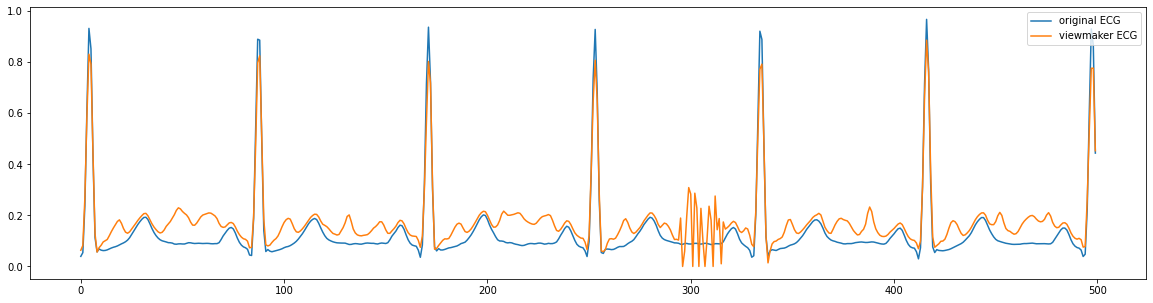

In [26]:
plt.figure(figsize=(20,5))
plt.plot(data_test.numpy().ravel()[:500], label='original ECG')
plt.plot(data_test_view[0][0][:500].detach().numpy(), label='viewmaker ECG')
plt.legend()


In [45]:
aug_test = data_test.numpy().ravel().reshape((1,-1))

In [46]:
(aug_test - np.min(aug_test, axis=1, keepdims=True))/(np.max(aug_test, axis=1, keepdims=True) - np.min(aug_test, axis=1, keepdims=True) + 0.00000001)

array([[0.7708135 , 0.7897727 , 0.7448559 , ..., 0.54667586, 0.5524672 ,
        0.491636  ]], dtype=float32)

In [47]:
plt.figure(figsize=(20,5))
plt.plot(aug.magnitude_warp(aug_test).ravel()[:500])

ValueError: `x` must be strictly increasing sequence.

<Figure size 1440x360 with 0 Axes>

In [35]:
normalize(testSet.__getitem__(1)[0].ravel())

array([0.98620688, 1.        , 0.96354679, ..., 0.66699507, 0.67192118,
       0.64433498])

In [43]:
data_test = testSet.__getitem__(1)[0]

In [43]:
data_test.reshape((-1,1))
(data_test.reshape((-1,1)) - np.min(data_test.reshape((-1,1)), axis=1, keepdims=True))/(np.max(data_test.reshape((-1,1)), axis=1, keepdims=True) - np.min(data_test.reshape((-1,1)), axis=1, keepdims=True) + 0.00000001)

TypeError: min() received an invalid combination of arguments - got (keepdims=bool, axis=int, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
 * (name dim, bool keepdim)


In [55]:
data_test - np.min(data_test, axis=1, keepdims=True)

array([[9.53769312, 9.6710876 , 9.31854539, ..., 6.45056779, 6.49820864,
        6.23142001]])

In [57]:
((data_test - np.min(data_test, axis=1, keepdims=True))/(np.max(data_test, axis=1, keepdims=True) - np.min(data_test, axis=1, keepdims=True) +                 0.00000001)).shape

(1, 3000)

 ...]

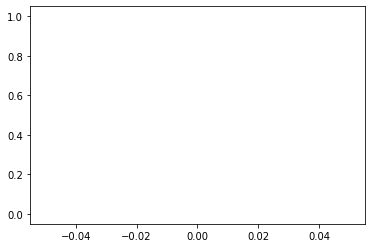

In [49]:
import numpy as np
plt.plot((data_test - np.min(data_test, axis=1, keepdims=True))/(np.max(data_test, axis=1, keepdims=True) - np.min(data_test, axis=1, keepdims=True) +                 0.00000001).ravel())